In [33]:
import random
import sys
from io import BytesIO
import gzip
import struct
import mxnet as mx
from mxnet import nd
from mxnet.gluon import nn
from mxnet import gluon
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import namedtuple

In [2]:
def read_data(label_url, image_url):
    with gzip.open(label_url) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(image_url, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(
            len(label), rows, cols)
    return (label, image)


In [3]:
def Get_image_lable(img, lable):
    x = [random.randint(0, 9) for x in range(3)]
    black = np.zeros((28, 28), dtype='uint8')
    for i in range(3):
        if x[i] == 0:
            img[:, i * 28:(i + 1) * 28] = black
            lable[i] = 10
    return img, lable

In [10]:
def GetImage(image,lable):
    num = [random.randint(0, 5000 - 1)
           for i in range(3)]

    img, _ = Get_image_lable(
        np.hstack((image[x] for x in num)), np.array([lable[x] for x in num]))
    imgw = 255 - img
    cv2.imwrite("img.jpg", imgw)
    img = np.multiply(img, 1 / 255.0)
    img = img.reshape(1, 1, 28, 84)
    return img,imgw

In [4]:
class OCRIter():
    def __init__(self, count, batch_size, num_label, height, width, lable, image):
        self.batch_size = batch_size
        self.count = count
        self.height = height
        self.width = width
        self.lable = lable
        self.image = image
        self.num_label = num_label

    def __iter__(self):
        for k in range(self.count / self.batch_size):
            data = []
            label = []
            for i in range(self.batch_size):
                num = [random.randint(0, self.count - 1)
                       for i in range(self.num_label)]
                img, lab = Get_image_lable(np.hstack(
                    (self.image[x] for x in num)), np.array([self.lable[x] for x in num]))
                img = np.multiply(img, 1 / 255.0)
                data.append(img.reshape(1, self.height, self.width))
                label.append(lab)
                
            data_all = nd.array(data,ctx=mx.gpu())
            label_all = nd.array(label,ctx=mx.gpu())
            yield data_all,label_all

In [5]:
def Accuracy(label, pred):
    label = label.T.reshape((-1, ))
    hit = 0
    
    for i in range(pred.shape[0] / 3):
        ok = True
        for j in range(3):
            k = i * 3 + j
            if np.argmax(pred[k]) != int(label[k]):
                ok = False
        if ok:
            hit += 1
    return hit

In [6]:
class Cont(nn.HybridBlock):
    def __init__(self,**kwargs):
        super(Cont,self).__init__(**kwargs)
        with self.name_scope():
            self.dese0 = nn.Dense(11)
            self.dese1 = nn.Dense(11)
            self.dese2 = nn.Dense(11)
    def hybrid_forward(self,F,X):
        return F.concat(*[self.dese0(X),self.dese1(X),self.dese2(X)],dim=0)


In [7]:
def GetNet():
    net = nn.HybridSequential()
    with net.name_scope():
        net.add(nn.Conv2D(channels=32,kernel_size=5,activation='relu'))
        net.add(nn.MaxPool2D(pool_size=2,strides=1))
        
        net.add(nn.Conv2D(channels=32,kernel_size=5,activation='relu'))
        net.add(nn.AvgPool2D(pool_size=2,strides=1))
        
        net.add(nn.Conv2D(channels=32,kernel_size=3,activation='relu'))
        net.add(nn.AvgPool2D(pool_size=2,strides=1))
        
        net.add(nn.Conv2D(channels=32,kernel_size=3,activation='relu'))
        net.add(nn.AvgPool2D(pool_size=2,strides=1))
        
        net.add(nn.Flatten())
        net.add(nn.Dense(256))
        net.add(Cont())
        return net

In [35]:
def predict(img,mod):
    mod.forward(Batch([mx.nd.array(img)]))
    out = mod.get_outputs()
    prob = out[0].asnumpy()

    line = ''
    for i in range(prob.shape[0]):
        line += str(np.argmax(prob[i])
                    if int(np.argmax(prob[i])) != 10 else ' ')
    return line

In [9]:
(train_lable, train_image) = read_data(
        '../train-labels-idx1-ubyte.gz', '../train-images-idx3-ubyte.gz')
(test_lable, test_image) = read_data(
        '../t10k-labels-idx1-ubyte.gz', '../t10k-images-idx3-ubyte.gz')

将Gluon模型转换成Symbol类型保存到硬盘，并且保存Gluon模型参数至硬盘

In [22]:
net = GetNet()
net.load_params('../cnn_mnist_gluon',ctx=mx.cpu())
net.hybridize()
x = mx.sym.var('data')
y = net(x)
y.save('../cnn_mnist_gluon.json')
net.collect_params().save('../cnn_mnist_gluon.params')

加载Symbol模型网络，绑定模型至mod，加载模型参数，设置模型参数

In [45]:
symnet = mx.symbol.load('../cnn_mnist_gluon.json')
mod = mx.mod.Module(symbol=y, context=mx.cpu())
mod.bind(data_shapes=[('data', (1, 1, 28, 84))])
params = nd.load('../cnn_mnist_gluon.params')
mod.set_params(arg_params=params,aux_params={})
Batch = namedtuple('Batch', ['data'])

<Symbol hybridsequential5_cont0_concat0>


D:\miniconda3\envs\gluon\lib\site-packages\mxnet\module\base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
D:\miniconda3\envs\gluon\lib\site-packages\mxnet\module\base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


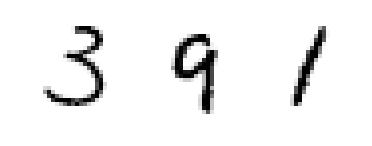

391


In [56]:
img,imgw = GetImage(test_image,test_lable)
line = predict(img,mod)
plt.imshow(imgw, cmap='Greys_r')
plt.axis('off')
plt.show()
print(line)